Plot the profiler trajectories and the measured profiles.

In [1]:
import alborexdata
import os
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import datetime
import cmocean
import alborexpaths
from alborexpaths import coordinates1, coordinates2
from matplotlib import rcParams
rcParams.update({'font.size': 16})

importing configuration from alborexpaths


/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
logger = alborexdata.configure_logging("./logs/alborexFigure7.log")

## Load data 
### Coastline

In [3]:
if os.path.exists(alborexpaths.coastfile):
    logger.info("{0} exists".format(alborexpaths.coastfile))
    loncoast, latcoast = alborexdata.read_lonlat_coast(alborexpaths.coastfile)
else:
    logger.warning("{0} does't exist".format(alborexpaths.coastfile))  

2019-01-12 14:58:25,411 - alborex_logger - INFO - ../data/coastline_f.dat exists


### Profilers

In [13]:
profilers = []

for ii, pfile in enumerate(alborexpaths.profilerfiles):
    profiler = alborexdata.Profiler()
    profiler.get_from_netcdf(pfile)
    logger.info("Total: {}".format(len(profiler.dates)))
    # Correction on the dates of the 3rd profiler:
    if ii == 2:
        for jj in range(0, len(profiler.dates)):
            profiler.dates[jj] = profiler.dates[jj].replace(year=2014)
    profiler.select_dates(finaldate=datetime.datetime(2014, 6, 15))
    logger.info("During the mission: {}".format(profiler.dates.count()))
    profilers.append(profiler)

2019-01-12 15:07:08,110 - alborex_logger - INFO - Total: 12
2019-01-12 15:07:08,114 - alborex_logger - INFO - During the mission: 10
2019-01-12 15:07:13,259 - alborex_logger - INFO - Total: 71
2019-01-12 15:07:13,278 - alborex_logger - INFO - During the mission: 17
2019-01-12 15:07:21,717 - alborex_logger - INFO - Total: 2507
2019-01-12 15:07:21,748 - alborex_logger - INFO - During the mission: 509


### Front position

In [6]:
f = alborexdata.Front()
f.get_from_file(alborexpaths.frontfile)
f.smooth()

## Plot
Create the projection

In [7]:
coordinates = (-1.5, 1., 35.25, 37.25)
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='h')

## Loop on the files

In [11]:
finaldate = datetime.datetime(2014, 6, 15)

2019-01-12 15:07:21,963 - alborex_logger - INFO - Making figure fig10


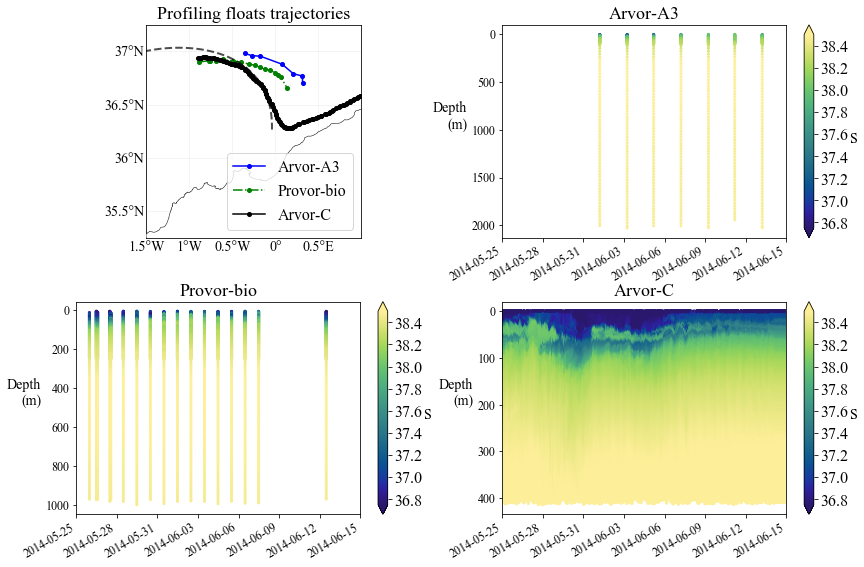

In [14]:
figname = "fig10"
figtitle = "Profiling floats trajectories"
logger.info("Making figure {0}".format(figname))

tmin, tmax = 18., 20.5

fig = plt.figure(figsize=(14, 10))
# 1st subplot: trajectories

ax0 = plt.subplot(2, 2, 1)
m.ax = ax0

# Add the coastline
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True, zorder=4, ax=ax0)

alborexdata.add_map_grid(m, coordinates, dlon=.5, dlat=.5,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6", ax=ax0)

m.fillcontinents(color="w", zorder=3, ax=ax0)
# Front position
m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True, zorder=5, alpha=.7)
plt.title(figtitle, fontsize=18)

colorlist = ["b", "g", "k"]
stylelist = ["-", "-.", "-"]
namelist = ["Arvor-A3", "Provor-bio", "Arvor-C"]

ii = 0
for p in profilers:
      
    # Hard-coded !!!!
    # because the 1st profiler has some issues in the first positions
    if ii == 0:
        p.lon = p.lon[3:]
        p.lat = p.lat[3:]
        p.dates = p.dates[3:]
        p.depth = p.depth[3:, :]
        p.temperature = p.temperature[3:, :]
        p.salinity = p.salinity[3:, :]
    
    m.plot(p.lon, p.lat, "o:", color=colorlist[ii], 
           linestyle=stylelist[ii], ms=4, latlon=True, label=namelist[ii])
    
    ii += 1
    
    # Select good dates
    p.select_dates(finaldate=finaldate)
    ndepth = p.depth.shape[1]
    dates = np.matlib.repmat(p.dates.T, ndepth, 1)
    dates = dates.transpose()

    ax = plt.subplot(2, 2, ii+1)
    #ax2.plot(p.salinity, p.temperature, "ko", ms=2)
    scat = ax.scatter(dates, p.depth, s=4, c=p.salinity, 
                      vmin=36.75, vmax=38.5,
                      cmap=cmocean.cm.haline)
    ax.set_title(namelist[ii-1], fontsize=18)
    #plt.yticks(range(0, 2000, 100))
    #plt.ylim(0, 400.)
    plt.ylabel("Depth\n(m)", fontsize=14, rotation=0, ha="right")
    plt.xlim(datetime.datetime(2014, 5, 25), finaldate)
    cb = plt.colorbar(scat, extend="both")
    cb.set_label("S", rotation=0, fontsize=14)
    plt.gca().invert_yaxis()
    plt.tick_params(axis='both', which='major', labelsize=12)
    fig.autofmt_xdate()


ax.set_title(namelist[ii-1], fontsize=18)
# plt.ylim(0, 400.)
plt.xlim(datetime.datetime(2014, 5, 25), finaldate)
#plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=12)
fig.autofmt_xdate()

ax0.legend(fontsize=16, loc=4)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(alborexpaths.figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## T-S diagram

2019-01-12 15:07:43,792 - alborex_logger - INFO - Making figure fig10b


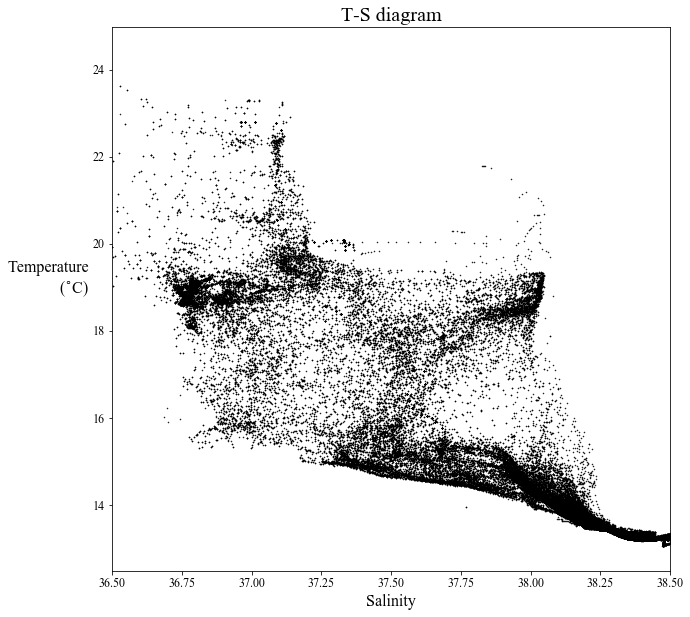

In [15]:
figname = "fig10b"
figtitle = "Profiling floats trajectories"
logger.info("Making figure {0}".format(figname))
finaldate = datetime.datetime(2014, 6, 15)

fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot(111)

ii = 0
for p in profilers:
    
    plt.plot(p.salinity.compressed(), p.temperature.compressed(), "ko", ms=.5)

np = p.depth.shape[0]
depth4interp = 25
t, s = [], []
ii = 0
dd = p.dates[0]

while (dd <= finaldate):
    depthinterp = p.depth[ii]
    tempinterp = p.temperature[ii]
    saltinterp = p.salinity[ii]
    f1 = interpolate.interp1d(depthinterp, tempinterp)
    f2 = interpolate.interp1d(depthinterp, saltinterp)
    t.append(f1(depth4interp))
    s.append(f2(depth4interp))
    ii += 1
    dd = p.dates.data[ii]
    
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel("Temperature\n ($^{\circ}$C)", rotation=0, ha="right")
plt.xlabel("Salinity")
plt.xlim(36.5, 38.5)
plt.title("T-S diagram", fontsize=20)
plt.savefig(os.path.join(alborexpaths.figdir, figname), dpi=300, bbox_inches='tight')

plt.show()
plt.close()